# Optimize left_errors and lin_F_map

In [249]:
import pygsti.modelpacks.smq1Q_XYZI as modelpack1q
import pygsti.modelpacks.smq2Q_XYCNOT as modelpack2q
from util import *
import matplotlib.pyplot as plt

In [506]:
from scipy.linalg import expm, logm
from functools import cached_property

class CircuitAnalyzer:
    """Performs operations on a given pygsti Circuit object,
    which is part of a given GateSet.
    
    The Circuit's state prep and measurement operators are set to the default values,
    but can be specified by their names, as long as they are part of the GateSet."""
    def __init__(self, circuit, gateset, state_prep='rho0', povm='Mdefault', optimized=True):
        self.gateset = gateset
        self.circuit = circuit
        # Extracts the gates in the circuit as a list of labels
        self.gates = list(circuit.layertup)
        # Finds their PTMs (pauli transfer matrices)
        self.gate_matrices = [gateset.target_op(gate) for gate in self.gates]
        self.N = self.gate_matrices[0].shape[0]
        if optimized:
            self.gate_mat_dict = {gate: self.gateset.target_op(gate) for gate in self.gateset.gate_labels}
            self.gate_matinv_dict = {gate: np.linalg.inv(self.gateset.target_op(gate)) for gate in self.gateset.gate_labels}
            self.all_features = np.array(list(self.gateset.feature_map.values()))
            self.process_labels = ([state_prep]+self.gates+[povm])[::-1]
            self.all_labels = list(self.gateset.egen_from_label.keys())
        else:
            # Extracts the error matrices corresponding to each of these gates
            self.gate_errors = [gateset.error_generator_of(gate) for gate in self.gates]
            # Also extracts the error terms corresponding to SPAM (state prep + measurement)
            self.state_prep_error = gateset.error_generator_of(state_prep)
            self.povm_error = gateset.error_generator_of(povm)

    # @cached_property
    @property
    def left_errors(self):
        """Moves all gate errors to the left of the circuit,
        and returns the resulting list of conjugated error generators.
        
        NOTE: In our Circuit object, the gates are ordered
        left-to-right from first-applied to last-applied.
        However, the error terms in the result of this function, are ordered
        left-to-right as they would be in matrix multiplication."""
        
        n = len(self.gate_errors)
        left_errors = []
        # The first error in the result is the measurement error,
        # which is unchanged (doesn't need conjugating)
        left_errors.append(self.povm_error)
        # Compute the matrices by which each error will be conjugated
        # These are products of successive gates, in reverse order
        conjugators = [np.eye(self.gate_errors[0].shape[0])]
        for gate in reversed(self.gate_matrices):
            conjugators.append((gate @ conjugators[-1]).round(10))
        # Next, process the gate errors from the end of the list to its beginning
        # Because that's the order they'll appear in the resulting matrix mult
        for i in range(n):
            # Note that i = 0 conjugates by the identity; the last gate is unchanged
            error = self.gate_errors[n-i-1]
            conjugator = conjugators[i]
            left_errors.append(conjugator * error * np.linalg.inv(conjugator))
        # Finally, add the State prep error;
        # We must conjugate it through all gates in the circuit
        left_errors.append(conjugators[-1] * self.state_prep_error * np.linalg.inv(conjugators[-1]))
        return left_errors
    


    # @cached_property
    @property
    def linear_F_map(self):
        """Returns the linear approximation of the F map,
        after moving all errors to the left. This approximation assumes they commute.
        The result is a function of the error terms of the gate set.
        """
        # Simply take the sum of all error generators after moving them to the left
        return sum(self.left_errors[1:], self.left_errors[0])
    
    @cached_property
    def order2_F_map(self):
        """Returns the order-2 approximation of the F map,
        after moving all errors to the left, and applying order-2 BCH.
        The result is a function of the error terms of the gate set.
        """
        # Start with the sum of all error terms
        result = sum(self.left_errors[1:], self.left_errors[0])
        # Then add half the commutator between each pair of errors
        comm = lambda X, Y: X@Y - Y@X
        n = len(self.left_errors)
        for i in range(n):
            for j in range(i, n):
                result += comm(self.left_errors[i], self.left_errors[j]) / 2
                result = sp.expand(result)
        return result
    
    @cached_property
    def circuit_matrix(self):
        """Returns the PTM of the target circuit."""
        # Multiply all the gates together
        # from first-applied (left) to last-applied (right)
        circuit = self.gate_matrices[0]
        for m in self.gate_matrices[1:]:
            circuit = circuit @ m
        return circuit
    
    def simulate(self, substitutions, rho, mu):
        """Substitute all error terms in the circuit with the given values,
        then show the output of the circuit (outcome probabilities),
        from state rho and with measurement mu."""
        circuit = self.circuit_matrix
        # Now substitute all generator terms with the given values
        # Then exponentiate the generators, and multiply them with the circuit
        subs_errors = [m.subs(substitutions) for m in self.left_errors]
        subs_errors = [np.array(m).astype(np.float64) for m in subs_errors]
        subs_errors = [expm(m) for m in subs_errors]
        for m in subs_errors[::-1]:
            circuit = m @ circuit
        # evaluate at mu, rho
        return mu @ circuit @ rho
    
    def approx_simulate(self, substitutions, rho, mu, order=1):
        """Substitute all error terms in the circuit with the given values,
        then show the APPROXIMATE output of the circuit (outcome probabilities),
        from state rho and with measurement mu, using the given approx order (1 or 2)."""
        circuit = self.circuit_matrix
        # Compute the first-order approximation of the error term
        if order == 1:
            error = self.linear_F_map
        else:
            error = self.order2_F_map
        # Now substitute all generator terms with the given values
        # Then exponentiate the generator, and multiply it with the circuit
        error = error.subs(substitutions)
        error = np.array(error).astype(np.float64)
        error = expm(error)
        circuit = error @ circuit
        # evaluate at mu, rho
        return mu @ circuit @ rho
    
    def linear_variation(self, egen_lbl):
        """
        Returns a linear combination of sympy variables that quantifies how 
        linear varitations in model parameters effect end of circuit rates
        """
        F = self.linear_F_map
        dgen = egenlbl_to_dual(egen_lbl, gs.num_qubits)
        return np.trace(dgen.conj().T@F)
    
    def variation_matrix(self):
        """
        Returns the linear varation matrix that quantifies how 
        variations in local params affect variations in eoc params
        column space: local params in the order provided in gate_set.local_labels
        row space: error generator params in the order provided by gate_set.labels
        """
        eoc_lbls = LindbladErrorgen.from_error_generator(4**gs.num_qubits).coefficient_labels()
        local_params = gs.vec
        varmat = np.zeros((len(eoc_lbls), len(local_params)))
        for id_eoc, eoc_lbl in enumerate(eoc_lbls):
            var_combo = self.linear_variation(eoc_lbl)
            for id_local, p in enumerate(local_params):
                varmat[id_eoc, id_local] = var_combo.coeff(p)
        return varmat
    
    ##############################################
    ############### NAM's addition ###############
    @property
    def left_errors_optimized(self):
        '''
        Conjugate features instead and multiply symbolic rates only at the end
        '''
        ## 1st two from left are not conjugated. n+2 (meas + gates + prep)
        conjugators = [np.eye(self.all_features.shape[-1])]*2
        conjugators_inv = [np.eye(self.all_features.shape[-1])]*2
        left_errors = [self.all_features]*2
        ### for i in range(2):
        ###     left_errors[i] = error_mat(left_errors[i].round(10), self.process_labels[i], self.gateset)
        for i,gate in enumerate(reversed(ca.gates)):
            conjugators.append(self.gate_mat_dict[gate] @ conjugators[-1]) # like in left_errors
            conjugators_inv.append(conjugators_inv[-1] @ self.gate_matinv_dict[gate]) # like in left_errors
            ### BUG - this should be the correct order! ###
            # conjugators.append(conjugators[-1] @ self.gate_mat_dict[gate]) # G_k @ G_k-1 @ G_k-2...
            # conjugators_inv.append(self.gate_matinv_dict[gate] @ conjugators_inv[-1]) # ... Ginv_k-2 @ Ginv_k-1 @ Ginv_k
            left_errors.append(conjugators[-1] @ self.all_features @ conjugators_inv[-1])
            ### left_errors[-1] = error_mat(left_errors[-1].round(10), self.process_labels[i+2], self.gateset)
            
        # sum up contributions from the same gate    
        left_errors_optimized = dict(zip(self.all_labels,[0]*len(self.all_labels)))
        for i,process_label in enumerate(self.process_labels):
            left_errors_optimized[process_label] += left_errors[i]
        self.left_errors_features = left_errors
        return left_errors_optimized
    
    # @cached_property
    @property
    def linear_F_map_optimized(self):
        feature_keys = list(self.gateset.feature_map.keys())
        mat = np.zeros([self.N,self.N],dtype='O')
        for process_label,features in self.left_errors_optimized.items():
            if type(features) != int: # if a gate is not used, features == 0
                egen = self.gateset.egen_from_label[process_label]
                for x in egen.labels:
                    mat += egen.param_map[x]*features[feature_keys.index(x)].round(10)
        return sp.Matrix(mat)
    
    @property
    def linear_F_map_optimized_errormat(self):
        Fmap = np.zeros([self.N,self.N],dtype='O')
        for process_label,features in self.left_errors_optimized.items():        
            Fmap += error_mat(features.round(10), process_label, self.gateset)
        return Fmap

def error_mat(features, process_label, gateset):
    feature_keys = list(gateset.feature_map.keys())
    egen = gateset.egen_from_label[process_label]
    mat = np.zeros_like(features[0],dtype='O')
    for x in egen.labels:
        mat += egen.param_map[x]*features[feature_keys.index(x)]
    return sp.Matrix(mat)

## Time testing - 1q

In [522]:
edesign = modelpack1q.create_gst_experiment_design(200)
circ_list = edesign.circuit_lists[-1]
test_ind = np.arange(700,2266,350)
test_circuits = []
test_lens = []
for i,circ in enumerate(circ_list):
    if i in test_ind:
        print(len(circ))
        test_lens.append(len(circ))
        test_circuits.append(circ)
gs = GateSet(modelpack1q)

9
18
36
65
130


In [523]:
edesign = modelpack1q.create_gst_experiment_design(200)
circ_list = edesign.circuit_lists[-1]
for i,circ in enumerate(circ_list):
    if len(set(circ.layertup)) == 3:
        print('i, len, unique:',i,len(circ),len(set(circ.layertup)))

i, len, unique: 64 3 3
i, len, unique: 67 5 3
i, len, unique: 69 3 3
i, len, unique: 71 4 3
i, len, unique: 72 5 3
i, len, unique: 76 4 3
i, len, unique: 79 6 3
i, len, unique: 82 5 3
i, len, unique: 85 7 3
i, len, unique: 87 5 3
i, len, unique: 89 6 3
i, len, unique: 90 7 3
i, len, unique: 100 3 3
i, len, unique: 103 5 3
i, len, unique: 105 3 3
i, len, unique: 107 4 3
i, len, unique: 108 5 3
i, len, unique: 112 4 3
i, len, unique: 115 6 3
i, len, unique: 118 5 3
i, len, unique: 121 7 3
i, len, unique: 123 5 3
i, len, unique: 125 6 3
i, len, unique: 126 7 3
i, len, unique: 136 4 3
i, len, unique: 139 6 3
i, len, unique: 141 4 3
i, len, unique: 143 5 3
i, len, unique: 144 6 3
i, len, unique: 148 5 3
i, len, unique: 151 7 3
i, len, unique: 154 6 3
i, len, unique: 157 8 3
i, len, unique: 159 6 3
i, len, unique: 161 7 3
i, len, unique: 162 8 3
i, len, unique: 197 4 3
i, len, unique: 200 6 3
i, len, unique: 202 4 3
i, len, unique: 204 5 3
i, len, unique: 205 6 3
i, len, unique: 209 5 3
i, l

In [524]:
edesign = modelpack1q.create_gst_experiment_design(200)
circ_list = edesign.circuit_lists[-1]
test_ind = [64,1144,1380,1894,2048] #np.arange(700,2266,350)
test_circuits = []
test_lens = []
for i in test_ind:
    circ = circ_list[i]
    test_lens.append(len(circ))
    test_circuits.append(circ)
    print('len, unique:',len(circ),len(set(circ.layertup)),set(circ.layertup))
gs = GateSet(modelpack1q)

len, unique: 3 3 {Label(('Gxpi2', 0)), Label(('Gypi2', 0)), Label(('Gzpi2', 0))}
len, unique: 18 3 {Label(('Gxpi2', 0)), Label(('Gypi2', 0)), Label(('Gzpi2', 0))}
len, unique: 36 3 {Label(('Gxpi2', 0)), Label(('Gypi2', 0)), Label(('Gzpi2', 0))}
len, unique: 64 3 {Label(('Gxpi2', 0)), Label(('Gypi2', 0)), Label(('Gzpi2', 0))}
len, unique: 134 3 {Label(('Gxpi2', 0)), Label(('Gypi2', 0)), Label(('Gzpi2', 0))}


In [525]:
gs.gate_labels

[(), ('Gxpi2', 0), ('Gypi2', 0), ('Gzpi2', 0)]

In [526]:
np.array(list(gs.feature_map.values())).shape

(12, 4, 4)

In [513]:
init_time = []
init_time_opt = []
for circuit in test_circuits:
    t = %timeit -o -r4 CircuitAnalyzer(circuit, gs, optimized=False)
    t_opt = %timeit -o -r4 CircuitAnalyzer(circuit, gs)
    init_time.append([t.average,t.stdev])
    init_time_opt.append([t_opt.average,t_opt.stdev])
init_time = 1e3*np.array(init_time)
init_time_opt = 1e3*np.array(init_time_opt)

14.8 ms ± 71 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
831 µs ± 25.2 µs per loop (mean ± std. dev. of 4 runs, 1,000 loops each)
64.6 ms ± 8.79 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)
2.25 ms ± 443 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
123 ms ± 2.07 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)
4.58 ms ± 314 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
275 ms ± 29 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
5.45 ms ± 701 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
394 ms ± 2.71 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
9.05 ms ± 157 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)


In [514]:
Flin_time = []
Flin_time_opt = []
for circuit in test_circuits:
    ca = CircuitAnalyzer(circuit, gs, optimized=False)
    ca_opt = CircuitAnalyzer(circuit, gs)
    t = %timeit -o -r4 ca.linear_F_map
    t_opt = %timeit -o -r4 ca_opt.linear_F_map_optimized
    Flin_time.append([t.average,t.stdev])
    Flin_time_opt.append([t_opt.average,t_opt.stdev])
Flin_time = 1e3*np.array(Flin_time)
Flin_time_opt = 1e3*np.array(Flin_time_opt)

23.2 ms ± 420 µs per loop (mean ± std. dev. of 4 runs, 10 loops each)
14.6 ms ± 101 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
101 ms ± 1.35 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
14.6 ms ± 61.8 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
404 ms ± 7.66 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
14.7 ms ± 161 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
635 ms ± 6.48 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
14.9 ms ± 59.6 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)
1.01 s ± 7.14 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)
16.4 ms ± 184 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)


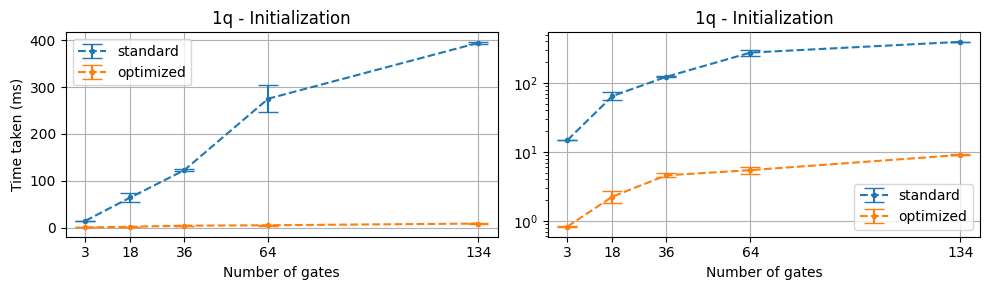

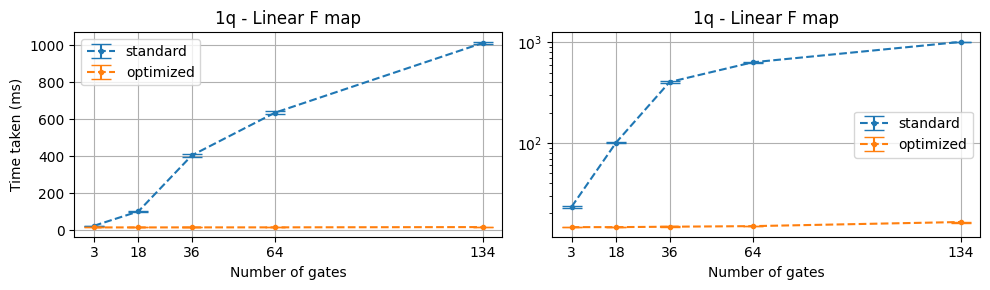

In [515]:
######### INIT #########
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.errorbar(test_lens,init_time[:,0],yerr=init_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,init_time_opt[:,0],yerr=init_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.ylabel('Time taken (ms)')
plt.title('1q - Initialization')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.errorbar(test_lens,init_time[:,0],yerr=init_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,init_time_opt[:,0],yerr=init_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.title('1q - Initialization')
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

####### LINEAR F MAP #########
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.errorbar(test_lens,Flin_time[:,0],yerr=Flin_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,Flin_time_opt[:,0],yerr=Flin_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.ylabel('Time taken (ms)')
plt.title('1q - Linear F map')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.errorbar(test_lens,Flin_time[:,0],yerr=Flin_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,Flin_time_opt[:,0],yerr=Flin_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.title('1q - Linear F map')
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

In [27]:
%timeit ca = CircuitAnalyzer(circ_list[-1], gs) # compute gate errors

425 ms ± 61.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit ca = CircuitAnalyzer(circ_list[-1], gs)

7.7 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit current_left_errors = ca.left_errors
%timeit current_left_errors = ca.left_errors_optimized

294 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
379 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%timeit current_left_errors = ca.left_errors_optimized # no sympy

10.3 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
# %%prun -s cumulative -q -l 30 -T prun0
left_errors = ca.left_errors
current_left_errors = ca_opt.left_errors_optimized

In [136]:
Flin = ca.linear_F_map
Flin_opt_errormat = ca_opt.linear_F_map_optimized_errormat
Flin_opt = ca_opt.linear_F_map_optimized
print(Flin-Flin_opt_errormat)
print(Flin-Flin_opt)

Matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
Matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])


In [137]:
%timeit Flin = ca.linear_F_map
%timeit Flin_opt_errormat = ca_opt.linear_F_map_optimized_errormat
%timeit Flin_opt = ca_opt.linear_F_map_optimized

1.12 s ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
26 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.3 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
print(open('prun0', 'r').read())

         1059621 function calls (1043232 primitive calls) in 0.690 seconds

   Ordered by: cumulative time
   List reduced from 165 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.690    0.690 {built-in method builtins.exec}
        1    0.000    0.000    0.688    0.688 <string>:1(<module>)
        1    0.009    0.009    0.688    0.688 510633363.py:29(left_errors)
 8540/140    0.007    0.000    0.656    0.005 decorators.py:99(binary_op_wrapper)
      140    0.001    0.000    0.654    0.005 repmatrix.py:331(_new)
      140    0.002    0.000    0.641    0.005 matrices.py:923(_handle_creation_inputs)
      560    0.004    0.000    0.638    0.001 matrices.py:1124(<listcomp>)
    22926    0.049    0.000    0.425    0.000 sympify.py:102(sympify)
     8960    0.015    0.000    0.419    0.000 common.py:3142(__getitem__)
11200/8960    0.064    0.000    0.348    0.000 numbers.py:1034(__new__)
       70    0.0

In [21]:
print(open('prun0', 'r').read())

         1313340 function calls (1311917 primitive calls) in 0.867 seconds

   Ordered by: cumulative time
   List reduced from 124 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.867    0.867 {built-in method builtins.exec}
        1    0.000    0.000    0.867    0.867 <string>:2(<module>)
        1    0.003    0.003    0.867    0.867 510633363.py:61(left_errors_optimized)
       71    0.031    0.000    0.860    0.012 510633363.py:177(error_mat)
    21726    0.025    0.000    0.796    0.000 decorators.py:224(_func)
    30413    0.041    0.000    0.521    0.000 sympify.py:102(sympify)
    13632    0.086    0.000    0.449    0.000 numbers.py:1034(__new__)
    20874    0.015    0.000    0.258    0.000 decorators.py:99(binary_op_wrapper)
    39547    0.041    0.000    0.235    0.000 cache.py:67(wrapper)
    13632    0.009    0.000    0.208    0.000 expr.py:215(__mul__)
    12141    0.021    0.000    0.

## Time testing - 2q

In [516]:
edesign = modelpack2q.create_gst_experiment_design(16)
circ_list = edesign.circuit_lists[-1]
for i,circ in enumerate(circ_list):
    if len(set(circ.layertup)) == 5:
        print('i, len, unique:',i,len(circ),len(set(circ.layertup)))

i, len, unique: 620 5 5
i, len, unique: 630 5 5
i, len, unique: 642 6 5
i, len, unique: 662 5 5
i, len, unique: 672 5 5
i, len, unique: 684 6 5
i, len, unique: 708 6 5
i, len, unique: 718 6 5
i, len, unique: 730 7 5
i, len, unique: 1206 6 5
i, len, unique: 1216 6 5
i, len, unique: 1228 7 5
i, len, unique: 1248 6 5
i, len, unique: 1258 6 5
i, len, unique: 1270 7 5
i, len, unique: 1294 7 5
i, len, unique: 1304 7 5
i, len, unique: 1316 8 5
i, len, unique: 2168 8 5
i, len, unique: 2178 8 5
i, len, unique: 2190 9 5
i, len, unique: 2210 8 5
i, len, unique: 2220 8 5
i, len, unique: 2232 9 5
i, len, unique: 2256 9 5
i, len, unique: 2266 9 5
i, len, unique: 2278 10 5
i, len, unique: 2833 6 5
i, len, unique: 2844 7 5
i, len, unique: 2850 6 5
i, len, unique: 2854 7 5
i, len, unique: 2855 7 5
i, len, unique: 2866 8 5
i, len, unique: 2877 7 5
i, len, unique: 2888 8 5
i, len, unique: 2894 7 5
i, len, unique: 2898 8 5
i, len, unique: 2899 8 5
i, len, unique: 2910 9 5
i, len, unique: 2913 6 5
i, len, 

In [519]:
edesign = modelpack2q.create_gst_experiment_design(16)
circ_list = edesign.circuit_lists[-1]
test_ind = [1,620,2278,7651,6275]
test_circuits = []
test_lens = []
for i in test_ind:
    circ = circ_list[i]
    test_lens.append(len(circ))
    test_circuits.append(circ)
    print('len, unique:',len(circ),len(set(circ.layertup)))
gs = GateSet(modelpack2q)

len, unique: 1 1
len, unique: 5 5
len, unique: 10 5
len, unique: 15 5
len, unique: 22 5


In [520]:
gs.gate_labels

[('Gxpi2', 1), ('Gypi2', 1), ('Gxpi2', 0), ('Gypi2', 0), ('Gcnot', 0, 1)]

In [521]:
np.array(list(gs.feature_map.values())).shape

(240, 16, 16)

In [461]:
init_time = []
init_time_opt = []
for circuit in test_circuits:
    t = %timeit -o -r2 CircuitAnalyzer(circuit, gs, optimized=False)
    t_opt = %timeit -o -r2 CircuitAnalyzer(circuit, gs)
    init_time.append([t.average,t.stdev])
    init_time_opt.append([t_opt.average,t_opt.stdev])
init_time = np.array(init_time)
init_time_opt = np.array(init_time_opt)

3.18 s ± 21.9 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.16 ms ± 28.3 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
7.22 s ± 37.7 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.33 ms ± 47.5 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
12.4 s ± 43.7 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.66 ms ± 27.7 µs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
17.8 s ± 148 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
2.04 ms ± 28.1 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
25.8 s ± 275 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
2.43 ms ± 63.2 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)


In [462]:
Flin_time = []
Flin_time_opt = []
for circuit in test_circuits:
    ca = CircuitAnalyzer(circuit, gs, optimized=False)
    ca_opt = CircuitAnalyzer(circuit, gs)
    t = %timeit -o -r2 ca.linear_F_map
    t_opt = %timeit -o -r2 ca_opt.linear_F_map_optimized
    Flin_time.append([t.average,t.stdev])
    Flin_time_opt.append([t_opt.average,t_opt.stdev])
Flin_time = np.array(Flin_time)
Flin_time_opt = np.array(Flin_time_opt)

4 s ± 32.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
4.26 s ± 32.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
15.1 s ± 10.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
17.4 s ± 125 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
26.5 s ± 66.4 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
21 s ± 111 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
42.3 s ± 570 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
46.4 s ± 766 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
53.7 s ± 109 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
20.8 s ± 165 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [464]:
circuit = test_circuits[3]
ca_opt = CircuitAnalyzer(circuit, gs)
t_opt = %timeit -o -r2 ca_opt.linear_F_map_optimized
# Flin_time_opt[3] = [t_opt.average,t_opt.stdev]

24.4 s ± 41.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


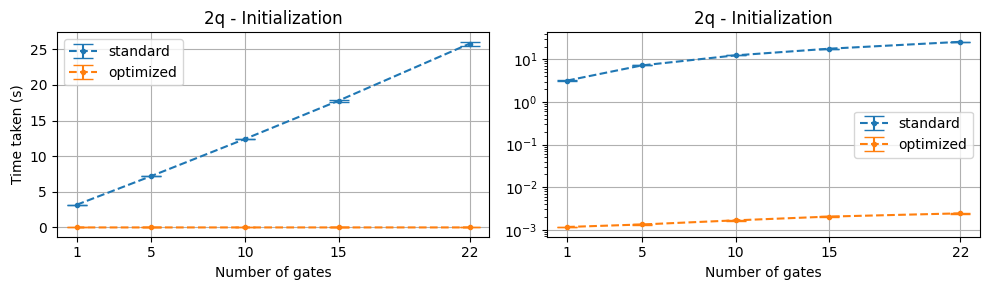

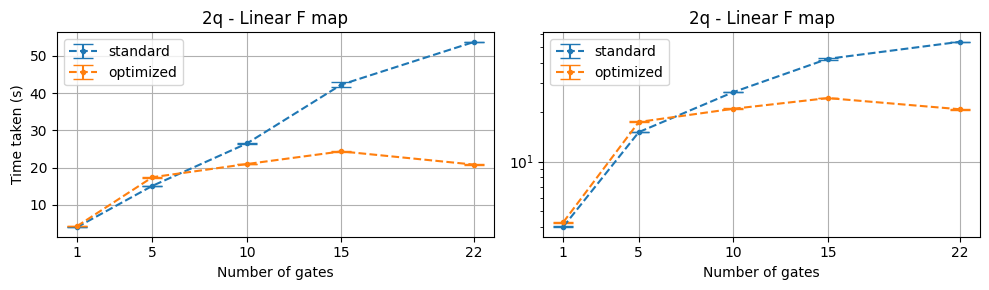

In [469]:
######### INIT #########
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.errorbar(test_lens,init_time[:,0],yerr=init_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,init_time_opt[:,0],yerr=init_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.ylabel('Time taken (s)')
plt.title('2q - Initialization')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.errorbar(test_lens,init_time[:,0],yerr=init_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,init_time_opt[:,0],yerr=init_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.title('2q - Initialization')
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

####### LINEAR F MAP #########
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.errorbar(test_lens,Flin_time[:,0],yerr=Flin_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,Flin_time_opt[:,0],yerr=Flin_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.ylabel('Time taken (s)')
plt.title('2q - Linear F map')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.errorbar(test_lens,Flin_time[:,0],yerr=Flin_time[:,1],
             fmt='o--',capsize=7,markersize=3,label='standard')
plt.errorbar(test_lens,Flin_time_opt[:,0],yerr=Flin_time_opt[:,1],
             fmt='o--',capsize=7,markersize=3,label='optimized')
plt.xticks(test_lens)
plt.xlabel('Number of gates')
plt.title('2q - Linear F map')
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

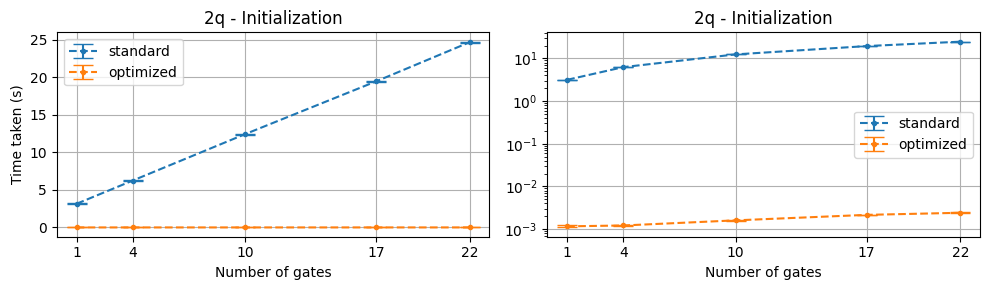

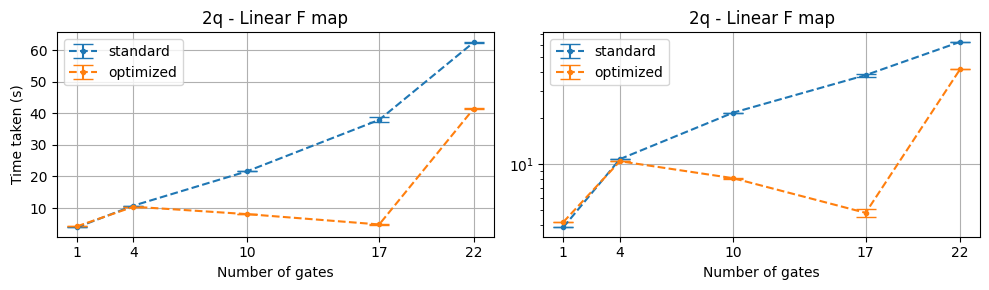

In [410]:
# when not using the whole gateset